In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import matplotlib.colors as mcolors

In [2]:
m = folium.Map([33.447046773463654, -112.08091337731709], zoom_start=5)

In [3]:
df_battery_manufacturing = pd.read_csv('./../../CSVs/RAW/battery-manufacturing.csv')
df_recycling_plants = pd.read_csv('./../../CSVs/RAW/lithium-reciclying-plants.csv', delimiter=';')
df_battery_collection_centers = pd.read_csv('./../../CSVs/RAW/Battery and e-waste collection centers USA.csv')

In [4]:
df_battery_manufacturing[['lon', 'lat']] = df_battery_manufacturing['WKT'].str.extract(r'POINT \(([^ ]+) ([^)]+)\)').astype(float)
df_battery_collection_centers[['lon', 'lat']] = df_battery_collection_centers['WKT'].str.extract(r'POINT \(([^ ]+) ([^)]+)\)').astype(float)
df_recycling_plants[['lon', 'lat']] = df_recycling_plants['WKT'].str.extract(r'POINT \(([^ ]+) ([^)]+)\)').astype(float)

In [5]:
df = pd.concat([df_battery_collection_centers[['name', 'lon', 'lat']], df_battery_manufacturing[['name', 'lon', 'lat']], df_recycling_plants[['name', 'lon', 'lat']]], ignore_index=True)

df

,name,lon,lat
0,"A1 Electronic Recycling,",-118.351477,34.041273
1,"eWaste U.S. Electronics Recycling,",-118.422810,34.204152
2,"CAL E-WASTE RECYCLE LLC,",-118.600035,34.213569
3,"E -Waste LA (Data Destruction Company),",-118.485689,34.201817
4,"pasadena tech recycle inc,",-118.416812,34.260691
...,...,...,...
76,ACE Green Recycling,-95.462811,29.738631
77,Redwood Materials,-119.741486,39.204376
78,American Battery Technology Company,-119.821745,39.524203
79,Tesla Giga Nevada,-119.439942,39.535707


In [6]:
rad_lat = np.radians(df['lat'])
rad_lon = np.radians(df['lon'])

df['x'] = np.cos(rad_lat) * np.cos(rad_lon)
df['y'] = np.cos(rad_lat) * np.sin(rad_lon)
df['z'] = np.sin(rad_lat)

In [7]:
X = df[['x', 'y', 'z']]

In [8]:
k_values = range(2, 75)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

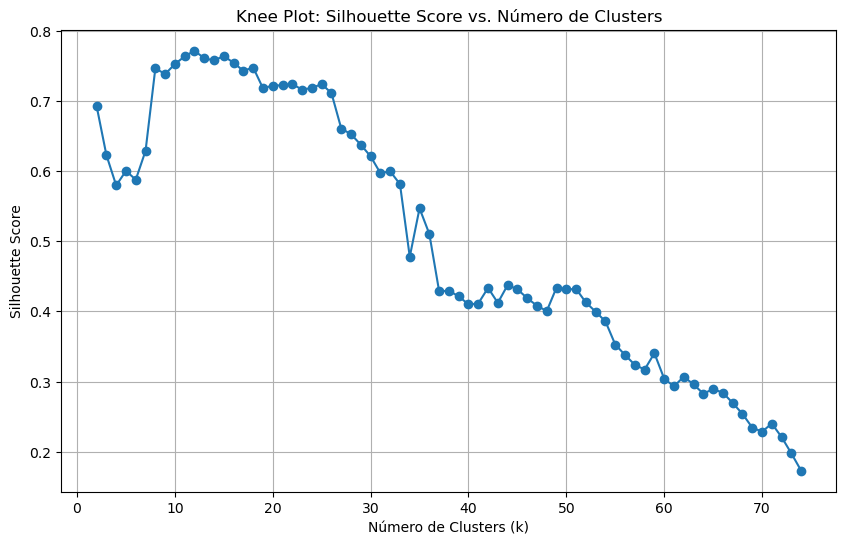

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Knee Plot: Silhouette Score vs. Número de Clusters')
plt.grid(True)
plt.show()

In [10]:
k=37
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)
sil_score = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.4289


In [11]:
df['cluster'] = cluster_labels
df

,name,lon,lat,x,y,z,cluster
0,"A1 Electronic Recycling,",-118.351477,34.041273,-0.393501,-0.729241,0.559790,6
1,"eWaste U.S. Electronics Recycling,",-118.422810,34.204152,-0.393650,-0.727348,0.562143,31
2,"CAL E-WASTE RECYCLE LLC,",-118.600035,34.213569,-0.395853,-0.726046,0.562279,31
3,"E -Waste LA (Data Destruction Company),",-118.485689,34.201817,-0.394459,-0.726935,0.562110,31
4,"pasadena tech recycle inc,",-118.416812,34.260691,-0.393309,-0.726901,0.562959,31
...,...,...,...,...,...,...,...
76,ACE Green Recycling,-95.462811,29.738631,-0.082662,-0.864354,0.496044,29
77,Redwood Materials,-119.741486,39.204376,-0.384416,-0.672821,0.632088,25
78,American Battery Technology Company,-119.821745,39.524203,-0.383598,-0.669210,0.636404,3
79,Tesla Giga Nevada,-119.439942,39.535707,-0.379067,-0.671640,0.636559,36


In [12]:
centroids = kmeans.cluster_centers_

centroids_lat = np.degrees(np.arcsin(centroids[:, 2]))
centroids_lon = np.degrees(np.arctan2(centroids[:, 1], centroids[:, 0]))

centroids_df = pd.DataFrame({'cluster': range(k), 'lat': centroids_lat, 'lon': centroids_lon})

print(centroids_df)

    cluster        lat         lon
0         0  35.671629 -105.984432
1         1  37.588311  -85.884508
2         2  36.032078 -115.114696
3         3  39.524203 -119.821745
4         4  29.879025  -95.514242
5         5  25.824448  -80.255040
6         6  34.073270 -118.318386
7         7  33.438702 -112.032933
8         8  33.457564  -82.065211
9         9  43.198152  -77.678291
10       10  32.943815  -96.874626
11       11  45.398127 -122.617841
12       12  36.687734 -119.776852
13       13  38.716168  -90.443272
14       14  35.892470  -79.640398
15       15  30.213270  -97.738171
16       16  34.392375 -103.195989
17       17  32.294561 -106.817496
18       18  39.569039  -84.259261
19       19  37.410836 -121.883575
20       20  33.934492  -84.227386
21       21  32.654283 -117.100203
22       22  38.904363  -86.919305
23       23  33.755959 -117.681719
24       24  35.147718 -106.634186
25       25  39.193254 -119.715203
26       26  32.878244 -111.769676
27       27  33.2138

In [13]:
unique_clusters = np.unique(cluster_labels)

colors = [plt.cm.viridis(i / (len(unique_clusters) - 1)) for i in range(len(unique_clusters))]

cluster_colors = {cluster: mcolors.to_hex(colors[i]) for i, cluster in enumerate(unique_clusters)}

df['color'] = df['cluster'].map(cluster_colors)

In [14]:
def mark_on_map(row):
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.7,
        popup=f"Cluster: {row['cluster']}"
    ).add_to(m)

df.apply(mark_on_map, axis=1)

m

In [15]:
def mark_centroids(row):
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"Centroid Cluster {row['cluster']}",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

centroids_df.apply(mark_centroids, axis=1)
m

In [16]:
df.to_csv('./../../CSVs/Geographical/GEOGRAPHICAL Combined.csv', index=False)